In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from ipywidgets import interact
from os import path

import plotly.graph_objects as go
import pandas as pd

from quimb import *
import time


In [120]:
from scipy.integrate import quad, nquad

# def Gz(z,a,b):
#     '''Direct solution to G(z), faster but has numerical instability for large V
#     a=  Lb/L2
#     b=  Lb*L1/L2
#     '''
#     a2= (b-1)/z +1j*0
#     a1= (a-z)/z +1j*0
#     a0= 1/z +1j*0
#     Q= (3*a1-a2**2)/9 +1j*0
#     R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
#     D= Q**3 + R**2 +1j*0
#     S= (R+D**0.5 +1j*0)**(1/3)
#     T= (R-D**0.5 +1j*0)**(1/3)
#     z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
#     return np.abs(np.imag(z4))

def Gz(z,a,b):
    '''Direct solution to G(z), faster but has numerical instability for large V
    a=  Lb/L2
    b=  Lb*L1/L2
    '''
    a2= (b-1)/z +1j*0
    a1= (a-z)/z +1j*0
    a0= 1/z +1j*0
    Q= (3*a1-a2**2)/9 +1j*0
    R= (9*a2*a1-27*a0-2*a2**3)/54 +1j*0
    D= Q**3 + R**2 +1j*0
    S= (R+D**0.5 +1j*0)**(1/3)
    z4= -a2/3 + (1-1j*sqrt(3))*Q/S/2-(1+1j*sqrt(3))/2*S
    return np.abs(np.imag(z4))

def Gz_eq(z_arr,a,b):
    ''' solves a cubic equation for G(z) numerically'''
    '''less efficient, but more reliable'''
#     if isinstance(z_arr, list):
#         z4=np.zeros(len(z_arr))
#         for i_z in range(len(z_arr)):
#             z= z_arr[i_z]
#             z4[i_z]=np.imag(np.roots([z,b-1,a-z,1]))[1]
#     else:
#         z4=np.imag(np.roots([z_arr,b-1,a-z_arr,1]))[1]
    if len(z_arr)>1:
        z4=np.zeros(len(z_arr))
        for i_z in range(len(z_arr)):
            z= z_arr[i_z]
            z4[i_z]=np.imag(np.roots([z,b-1,a-z,1]))[1]
    else:
        z4=np.imag(np.roots([z_arr,b-1,a-z_arr,1]))[1]

    return np.abs(z4)


def integrand_eq(z, a, b):
    return Gz_eq(z,a,b)

def integrand(z, a, b):
    return Gz(z,a,b)

def cdf_calc(a,b,x):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, np.inf]], args=(a, b),opts=[options,options])[0]
    return integral


ES was loaded!


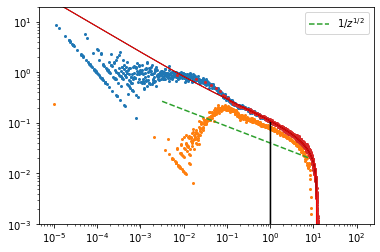

In [151]:
r=2 # local Hilbert space dim
La= 2
Lb= 2*La
Na=r**La
Nb=r**Lb
Nab = int(Na*Nb)

Lc_sw=[La]

n_sum=Nrep*Na*Nb


plt.figure()

for i_l in range(len(Lc_sw)):
    Lc=Lc_sw[i_l]
    Nc = r**Lc
    
    out_dir = 'data/' 
    f1= 'NS_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT0=npzfile['e0']
    print('ES was loaded!')


    num_bins1=2000
     
# # plt.plot(xx,0.1/xx**0.33,"--",label=r"$1/z^{1/3}$")
# # plt.plot(xx,0.04/xx**0.5,"--",label=r"$1/z^{1/2}$")

    nb1 = int(num_bins1/2)
    b1 = np.sort(np.concatenate((-np.logspace(-5,1.35,nb1+1),np.logspace(-5,2,nb1))))
    n0, bin_edges0 = np.histogram(vT0, bins=b1)
    n0= n0/np.sum(n0)/np.diff(bin_edges0)
    i_p = np.argwhere(b1>0)
    plt.plot(b1[i_p[:-2]],n0[i_p[:-2]],'o',markersize=2)
    i_n = np.argwhere(b1<=0)
    plt.plot(-b1[i_n],n0[i_n],'o',markersize=2)

    xx = np.logspace(-2.5,1)
    plt.plot(xx,0.04/xx**0.33,"--",label=r"$1/z^{1/2}$")
#     i_p = np.argwhere(b1>3e-2)
#     n_p = np.reshape(n0[i_p[:-2]],[len(i_p[:-2]),])
#     i_p_max = np.argwhere(n_p>2e-1)
#     bins_p = np.reshape(b1[i_p[:-2]],[len(i_p[:-2]),])
#     z = np.polyfit(np.log(bins_p[i_p_max][:,0]),np.log(n_p[i_p_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"k--", label=r"$z^{%.2f}$" % (z[0]))

#     i_n = np.argwhere(b1<-3e-2)
#     n_n = np.reshape(n0[i_n],[len(i_n),])
#     i_n_max = np.argwhere(n_n>7e-2)
#     bins_n = np.reshape(b1[i_n],[len(i_n),])
#     z = np.polyfit(np.log(-bins_n[i_n_max][:,0]),np.log(n_n[i_n_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"g--", label=r"$z^{%.2f}$" % (z[0]))
    
    n0, bin_edges0 = np.histogram(vT0, bins=num_bins1)
    bins_center0= (bin_edges0[0:num_bins1]+ bin_edges0[1:])/2
    n0= n0/np.sum(n0)/(bin_edges0[1]-bin_edges0[0])
    plt.plot(bins_center0,n0,'o',markersize=2)
#     i_p = np.argwhere(bins_center0>1e-12)
#     plt.plot(bins_center0[i_p],n0[i_p],'o',markersize=2)
#     i_n = np.argwhere(bins_center0<=0)
#     plt.plot(-bins_center0[i_n],n0[i_n],'o',markersize=2)
    

    a = Nc/Nb +1j*0
    b = Nc/Nb*Na +1j*0
    fx =  Nb/Nc
    fy =  Nc/pi/Nb
#     xplot= np.linspace(bins_center0.min(),bins_center0.max(),2000)/fx*1.1 #+1j*1e-12
    xplot= np.logspace(-5,2,2000)/fx*1.1 #+1j*1e-12
    yplot=np.abs(Gz(xplot,a,b))
    yplot_eq=Gz_eq(xplot,a+1j*0,b+1j*0)
    plt.plot(xplot*fx,fy*yplot_eq,"k",linewidth=1)
    plt.plot(xplot*fx,fy*yplot,"r",linewidth=1)

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3,2e1)
# plt.xlim(1e-5,2e1)
plt.legend()
plt.show()

# db0=bins_center0[-1]-bins_center0[0]
# db1=bins_center1[-1]-bins_center1[0]

# print('vertical ratio: ',np.max(n1)/np.max(n0))
# print('horizontal ratio: ',db1/db0)
# print(n_sum-Nrep*Na*Nb)

ES was loaded!


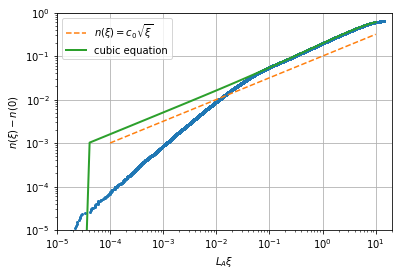

In [153]:
# cumulative probability

n_sum=Nrep*Na*Nb


plt.figure()

for i_l in range(len(Lc_sw)):
    Lc=Lc_sw[i_l]

    out_dir = 'data/' 
    f1= 'NS_Labc_%d_%d_%d.npz' % (La,Lb,Lc)
    fname = out_dir+f1

    npzfile = np.load(fname)
    vT0=npzfile['e0']
    print('ES was loaded!')
    
    vs = np.sort(vT0)
    i1=np.argmin(np.abs(vs))
    ns_0 = i1/len(vT0)
    plt.plot(vs,np.linspace(1/len(vT0),1,len(vT0))-ns_0,"o",markersize=2)
     
#     xx = np.logspace(-2.5,1)
# # plt.plot(xx,0.1/xx**0.33,"--",label=r"$1/z^{1/3}$")
# # plt.plot(xx,0.04/xx**0.5,"--",label=r"$1/z^{1/2}$")

#     i_p = np.argwhere(b1>3e-2)
#     n_p = np.reshape(n0[i_p[:-2]],[len(i_p[:-2]),])
#     i_p_max = np.argwhere(n_p>2e-1)
#     bins_p = np.reshape(b1[i_p[:-2]],[len(i_p[:-2]),])
#     z = np.polyfit(np.log(bins_p[i_p_max][:,0]),np.log(n_p[i_p_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"k--", label=r"$z^{%.2f}$" % (z[0]))

#     i_n = np.argwhere(b1<-3e-2)
#     n_n = np.reshape(n0[i_n],[len(i_n),])
#     i_n_max = np.argwhere(n_n>7e-2)
#     bins_n = np.reshape(b1[i_n],[len(i_n),])
#     z = np.polyfit(np.log(-bins_n[i_n_max][:,0]),np.log(n_n[i_n_max][:,0]),1)
#     plt.plot(xx,np.exp(z[1]+np.log(xx)*z[0]),"g--", label=r"$z^{%.2f}$" % (z[0]))
    
xx = np.logspace(-4,1)
plt.plot(xx,0.1*xx**0.5,"--", label=r"$n(\xi)=c_0\sqrt{\xi}$")

plt.plot(xplot*fx,nc-ns_0,"-",linewidth=2,label= "cubic equation")

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-5,1)
plt.xlim(1e-5,2e1)
plt.grid()
plt.legend()
plt.xlabel(r"$L_A \xi$")
plt.ylabel(r"$n(\xi)-n(0)$")
plt.show()

# db0=bins_center0[-1]-bins_center0[0]
# db1=bins_center1[-1]-bins_center1[0]

# print('vertical ratio: ',np.max(n1)/np.max(n0))
# print('horizontal ratio: ',db1/db0)
# print(n_sum-Nrep*Na*Nb)

In [152]:
def cdf_calc(a,b,x):
    '''Calculates logneg by \int P(z)|z| dz
    where P(z) is spectral density'''
    options={'limit':500}
    integral= nquad(integrand, [[-np.inf, x]], args=(a, b),opts=[options,options])[0]
    return integral

a = Nc/Nb +1j*0
b = Nc/Nb*Na +1j*0
fx =  Nb/Nc
fy =  Nc/pi/Nb
# xplot= np.linspace(bins_center0.min(),bins_center0.max(),100)/fx*1.1 #+1j*1e-12
xplot = np.logspace(-5,1,40)/fx
# yplot=np.abs(Gz(xplot,a,b))
#     yplot_eq=Gz_eq(np.ndarray.tolist(xplot),a+1j*0,b+1j*0)
# plt.plot(xplot*fx,fy*yplot,linewidth=1)

# cdf_calc(a,b,0.1)/pi
nc = np.zeros(len(xplot))
for i_x in range(len(xplot)):
    print(xplot[i_x])
    nc[i_x]=cdf_calc(a,b,xplot[i_x])/pi
    

2.5e-06
3.5627566757574983e-06
5.077294052261837e-06
7.235665311791879e-06
1.031156595725337e-05
1.469504018068728e-05
2.094194100170731e-05
2.9844416042860923e-05
4.253135699631473e-05
6.061155042705821e-05
8.637768236480545e-05
0.00012309706579266853
0.00017542595716759575
0.00025
0.0003562756675757498
0.0005077294052261843
0.0007235665311791879
0.001031156595725338
0.0014695040180687279
0.0020941941001707313
0.0029844416042860925
0.004253135699631473
0.006061155042705827
0.008637768236480554
0.012309706579266853
0.017542595716759573
0.025
0.03562756675757498
0.05077294052261847
0.07235665311791879
0.10311565957253391
0.1469504018068728
0.2094194100170731
0.29844416042860955


/nfshome/hshapourian/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.4253135699631473
0.6061155042705827
0.8637768236480545
1.2309706579266855
1.7542595716759593
2.5


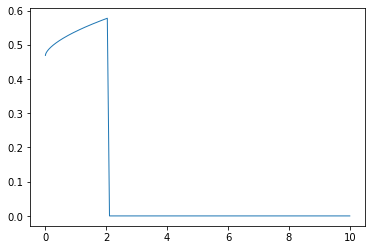

In [105]:
plt.plot(xplot*fx,nc,linewidth=1)


In [134]:
i1=np.argmin(np.abs(vs))
print(i1/len(vT0))

0.46875


In [154]:
Nab

64

In [149]:
1e-3*4096

4.096

In [150]:
1e-2*512

5.12

In [155]:
4e-2*64

2.56